This notebook shows basic usage of getFromAPI and builds the cosponsorship graph

In [52]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx

from getFromAPI import get_members, filter_active_senators, get_bills_cosponsored

In [15]:
assert os.path.isfile("APIKey.txt"), "You need an API Key for this notebook"

We get the list of active senators

In [16]:
senate_members = get_members()
senators = filter_active_senators(senate_members, verbose=True)

getting https://api.propublica.org/congress/v1/115/senate/members.json with headers {'X-API-Key': 'DeT68EIvdwBYsXyBrWYNTInTLH1XLXVRBhFzFCmp'} ...
...done
There are 100 active senators among the 105 senators


Then we get the last 20 bills cosponsored, for each senator, and also record the unique bills, if needed afterwards

In [19]:
senators_ids = [s["id"] for s in senators]

In [29]:
cosponsored = {}
all_bills = set()

for i, senator in enumerate(senators):    
    print(f"{i+1}/{len(senators)} Getting the last 20 bills cosponsored by {senator['first_name']} {senator['last_name']}")
    bills = get_bills_cosponsored(senator["id"])
    cosponsored[senator["id"]] = bills
    all_bills.update(bills)

print(f"Done. There are {len(all_bills)} unique bills cosponsored by {len(cosponsored)} senators.")

1/100 Getting the last 20 bills cosponsored by Lamar Alexander
2/100 Getting the last 20 bills cosponsored by Tammy Baldwin
3/100 Getting the last 20 bills cosponsored by John Barrasso
4/100 Getting the last 20 bills cosponsored by Michael Bennet
5/100 Getting the last 20 bills cosponsored by Richard Blumenthal
6/100 Getting the last 20 bills cosponsored by Roy Blunt
7/100 Getting the last 20 bills cosponsored by Cory Booker
8/100 Getting the last 20 bills cosponsored by John Boozman
9/100 Getting the last 20 bills cosponsored by Sherrod Brown
10/100 Getting the last 20 bills cosponsored by Richard Burr
11/100 Getting the last 20 bills cosponsored by Maria Cantwell
12/100 Getting the last 20 bills cosponsored by Shelley Capito
13/100 Getting the last 20 bills cosponsored by Benjamin Cardin
14/100 Getting the last 20 bills cosponsored by Thomas Carper
15/100 Getting the last 20 bills cosponsored by Bob Casey
16/100 Getting the last 20 bills cosponsored by Bill Cassidy
17/100 Getting the

Now we create the matrix cospons_mat, which is defined with:
    
    cospons_mat[i, j] = |common cosponsored bills betw. sen. i and j| / 20 if i != j, 0 otherwise

In [42]:
n_senators = len(senators)
cospons_mat = np.zeros((n_senators, n_senators))

In [44]:
senator_pairs = ((i, j, x, y) for i, x in enumerate(senators) for j, y in enumerate(senators) if not x["id"] == y["id"])

for i, j, s1, s2 in senator_pairs:
    common_bills = set(cosponsored[s1["id"]]).intersection(cosponsored[s2["id"]])
    commonality = len(common_bills) / 20.
    cospons_mat[i, j] = commonality
    cospons_mat[j, i] = commonality

print(cospons_mat)

[[0.   0.15 0.3  ... 0.15 0.15 0.25]
 [0.15 0.   0.25 ... 0.25 0.25 0.2 ]
 [0.3  0.25 0.   ... 0.2  0.15 0.2 ]
 ...
 [0.15 0.25 0.2  ... 0.   0.1  0.2 ]
 [0.15 0.25 0.15 ... 0.1  0.   0.2 ]
 [0.25 0.2  0.2  ... 0.2  0.2  0.  ]]


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:526: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):


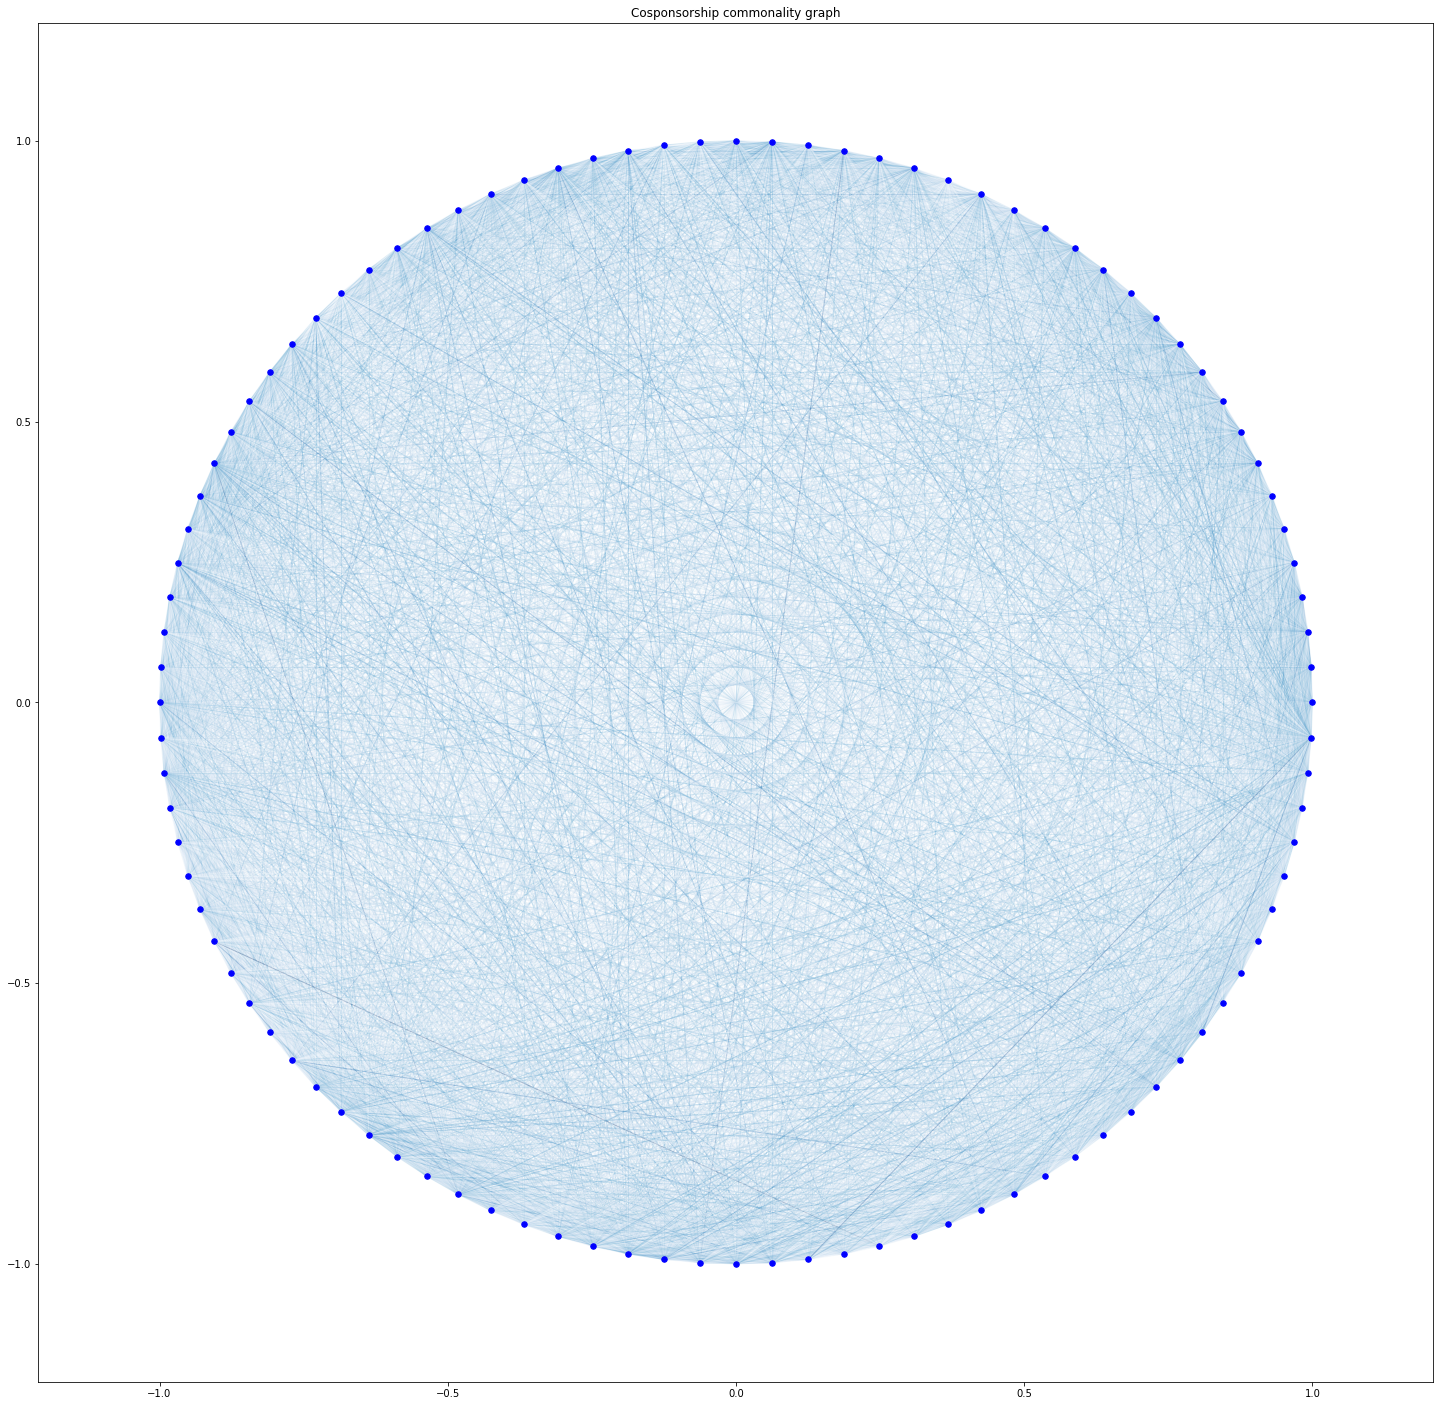

In [77]:
graph = nx.from_numpy_matrix(cospons_mat)
coords = nx.circular_layout(graph)

_, weights = zip(*nx.get_edge_attributes(graph,'weight').items())

plt.figure(figsize= (25,25))
plt.subplot(111)
plt.title("Cosponsorship commonality graph")
nx.draw_networkx_nodes(graph, coords, node_size=30, node_color='b')#, node_color=U[:,0], vmin = 0, vmax= 1)
nx.draw_networkx_edges(graph, coords, alpha=0.3, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)